Fitting phi values and then looking for trends with T, logg, or both

In [1]:
from base import *
import scipy.stats

In [16]:
def scatter(x, y):
    plt.scatter(x, y, s=5)

def hexbin(x, y):
    plt.hexbin(x, y, cmap='hot')
    plt.colorbar()

def plot_fit(x, y, fit_err=None):
    func = lambda x, A, B: A * x ** B
    (A, B), pcov = scipy.optimize.curve_fit(func, x, y, p0=(1, 1), sigma=fit_err)
    
    ax = plt.gca()
    xlim = ax.get_xlim()
    x = np.linspace(xlim[0], xlim[1], 100)
    y = func(x, A, B)
    plt.plot(x, y)
    plt.xlim(xlim)
    
    label = "{:.4G} x^{:.4F}".format(A, B)
    plt.gca().text(0.05, 0.9, label, transform=plt.gca().transAxes,
            bbox={'facecolor': 'white', 'alpha': 0.8, 'edgecolor': 'none'},
            fontsize=9)


def make_T_plotter(y_label, plot_cmd):
    def T_plotter(c, x_suffix, y_vals, ylim=None, fit_err=None):
        plot_cmd(c['Teff' + x_suffix], y_vals)
        plt.gca().invert_xaxis()
        plt.xlabel("Temperature (K)")
        plt.ylabel(y_label)
        plt.gca().autoscale()
        if ylim is not None:
            plt.ylim(*ylim)
        plot_fit(c['Teff' + x_suffix], y_vals, fit_err=fit_err)
    return T_plotter

def make_g_plotter(y_label, plot_cmd):
    def g_plotter(c, x_suffix, y_vals, ylim=None, fit_err=None):
        plot_cmd(c['logg' + x_suffix], y_vals)
        plt.gca().invert_xaxis()
        plt.xlabel("log(g) (cgs)")
        plt.ylabel(y_label)
        plt.gca().autoscale()
        if ylim is not None:
            plt.ylim(*ylim)
        plot_fit(c['logg' + x_suffix], y_vals, fit_err=fit_err)
    return g_plotter

def make_Tg_plotter():
    def Tg_plotter(c, suffix, z_vals, ylim=None, fit_err=None):
        x = c['Teff' + suffix]
        y = c['logg' + suffix]
        
        stat, x_edge, y_edge, binnumber = scipy.stats.binned_statistic_2d(
                x, y, z_vals, statistic='median', bins=100)
        XX, YY = np.meshgrid(x_edge, y_edge)

        render_mesh_plot(XX, YY, stat)
        plt.gca().invert_xaxis()
    return Tg_plotter

def render_mesh_plot(XX, YY, ZZ):
        good_vals = ZZ[np.isfinite(ZZ)]
        plt.pcolormesh(XX, YY, ZZ,
                #vmin=np.min(good_vals), vmax=np.max(good_vals))
                vmin=0, vmax=2)
        plt.colorbar().set_label("$\Phi$")
        plt.xlabel("Temperature (K)")
        plt.ylabel("log(g) (cgs)")
        plt.xlim(4500, 7000)
        plt.ylim(1.5, 5)

def outline_data(x, y, bins=100):
    H, x_edge, y_edge = np.histogram2d(
            x, y, bins=bins)
    x_edge = (x_edge[1:] + x_edge[:-1]) / 2
    y_edge = (y_edge[1:] + y_edge[:-1]) / 2
    XX, YY = np.meshgrid(x_edge, y_edge)

    H[ H > 0] = 1

    plt.contour(XX, YY, H, colors='black', alpha=0.5, levels=[0.5])

In [15]:
def make_four_plots(catalog, plotter1, plotter2=None, plotter3=None, plotter4=None, six_plots=False):
    if plotter2 is None:
        plotter2 = plotter1 
    if plotter3 is None:
        plotter3 = plotter2
    if plotter4 is None:
        plotter4 = plotter3
    
    # Added to the 221 etc. subplot codes
    offset = 0
    if six_plots:
        offset = 100

    c = catalog[ catalog['has_C'] == 1 ]

    # Plot 1
    Φ = fit_Φ(c['loggC'], c['TeffC'], c['MC'], c['F8'])

    plt.subplot(221 + offset)
    plotter1(c, 'C', Φ, ylim=(0.2, 1.8))
    plt.title("Fitted $Φ$ for Cranmer et al. (2014)")

    # Plot 2
    Ma = calc_Ma(c['loggC'], c['TeffC'])
    Φ = calc_Φ(Ma)

    plt.subplot(222 + offset)
    plotter2(c, 'C', Φ, ylim=(0.2, 1.8))
    plt.title("Modeled $Φ$ for Cranmer et al. (2014)")


    c = catalog[ catalog['TeffH'] < 7000]

    # Plot 3
    Φ = fit_Φ(c['loggH'], c['TeffH'], c['MH'], c['F8'])

    F8_error = c['F8'] - F8_from_logg(c['F8logg'] + c['E_F8logg'])
    error = Φ * np.sqrt(  (c['E_loggH'] / c['loggH'])**2
                        + (c['E_TeffH'] / c['TeffH'])**2
                        + (c['E_MH'] / c['MH'])**2
                        + (F8_error / c['F8'])**2 )

    print("{} good values".format(np.sum(Φ > 0)))
    print("{} bad values".format(np.sum(Φ <= 0) + np.sum(np.isnan(Φ))))
    print("{} total values".format(len(Φ)))

    plt.subplot(223 + offset)
    plotter3(c, 'H', Φ, ylim=(0.2, 3), fit_err=error)
    plt.title("Fitted $Φ$ for Bastien et al. (2016)")

    # Plot 4
    if six_plots:
        T = np.linspace(4500, 7000, 200)
        logg = np.linspace(1.5, 5, 200)
        TT, gg = np.meshgrid(T, logg)
        Ma = calc_Ma(gg, TT)
    else:
        Ma = calc_Ma(c['loggH'], c['TeffH'])
    phi = calc_Φ(Ma)

    plt.subplot(224 + offset)
    if six_plots:
        render_mesh_plot(TT, gg, phi.T)
        outline_data(c['TeffH'], c['loggH'])
        plt.gca().invert_xaxis()
    else:
        plotter4(c, 'H', phi, ylim=(0.2, 3), fit_err=error)
    plt.title("Modeled $Φ$ for Bastien et al. (2016)")


    if six_plots:
        plt.subplot(225 + offset)

        T = np.linspace(4500, 7000, 200)
        logg = np.linspace(1.5, 5, 200)
        TT, gg = np.meshgrid(T, logg)

        #phi = 4.216 * gg ** -1.1204 * T ** -2.3446
        phi = 2 * (gg/2.192) ** -1.1204 * (T/5110) ** -2.3446

        render_mesh_plot(TT, gg, phi)
        outline_data(c['TeffH'], c['loggH'])
        plt.gca().invert_xaxis()

        plt.title("Individual Fitting")


        plt.subplot(226 + offset)

        model = lambda T_and_logg, A, B, C: A * T_and_logg[0]**B * T_and_logg[1]**C
        popt, pconv = scipy.optimize.curve_fit(f=model,
                xdata=(c['TeffH'], c['loggH']),
                ydata=Φ, p0=(2*2.192*5110**2, -2.3, -1.1),
                sigma=error)

        fitted_Φ = model((TT, gg), *popt)
        render_mesh_plot(TT, gg, fitted_Φ)
        outline_data(c['TeffH'], c['loggH'])
        plt.gca().invert_xaxis()
        plt.title("Two-parameter Fitting")
        label = "{:.2G} T^{:.2F} logg^{:.2F}".format(*popt)
        plt.gca().text(0.5, 0.9, label, transform=plt.gca().transAxes,
                bbox={'facecolor': 'white', 'alpha': 0.8, 'edgecolor': 'none'},
                fontsize=9)



    plt.tight_layout()

27253 good values
0 bad values
27253 total values


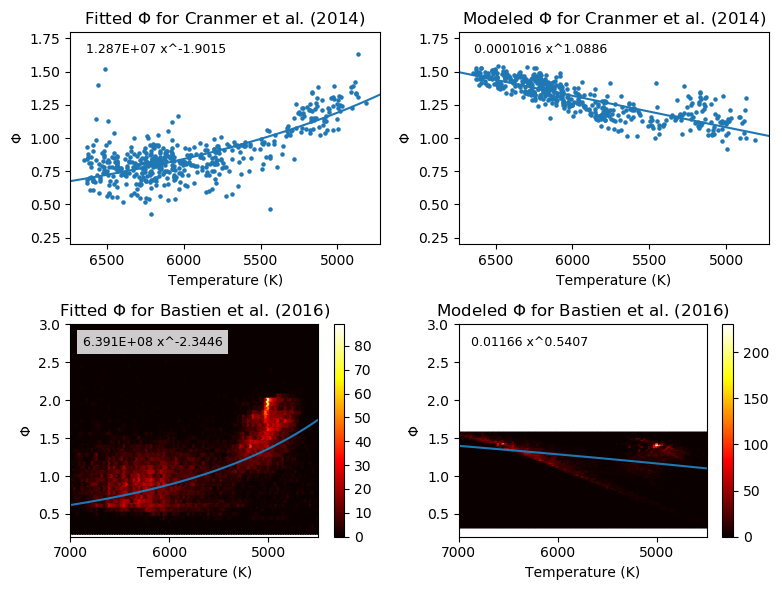

In [17]:
plt.figure(figsize=(8,6))
scat = make_T_plotter("Φ", scatter)
hex = make_T_plotter("Φ", hexbin)
make_four_plots(catalog, scat, plotter3=hex)
# plt.savefig('fitting_phi_T.png', dpi=200)

plt.show()

27253 good values
0 bad values
27253 total values


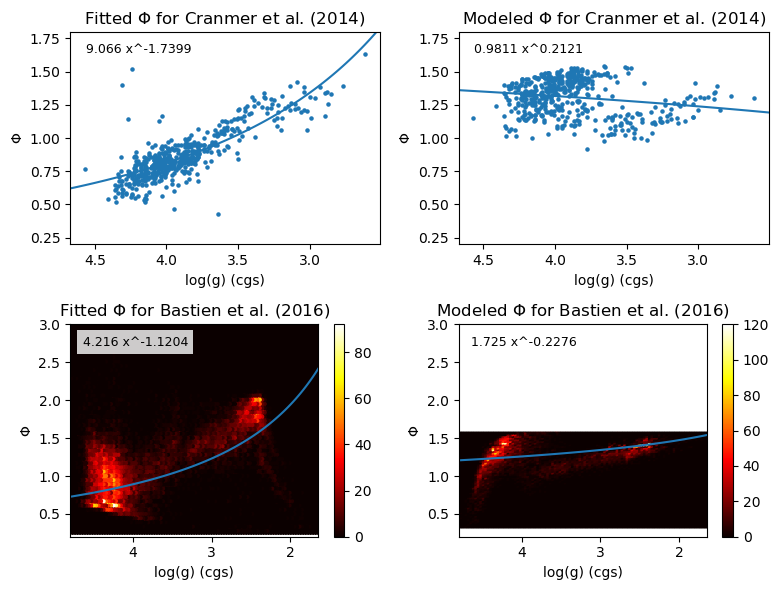

In [18]:
plt.figure(figsize=(8,6))
scat = make_g_plotter("Φ", scatter)
hex = make_g_plotter("Φ", hexbin)
make_four_plots(catalog, scat, plotter3=hex)
# plt.savefig('fitting_phi_logg.png', dpi=200)

plt.show()

27253 good values
0 bad values
27253 total values


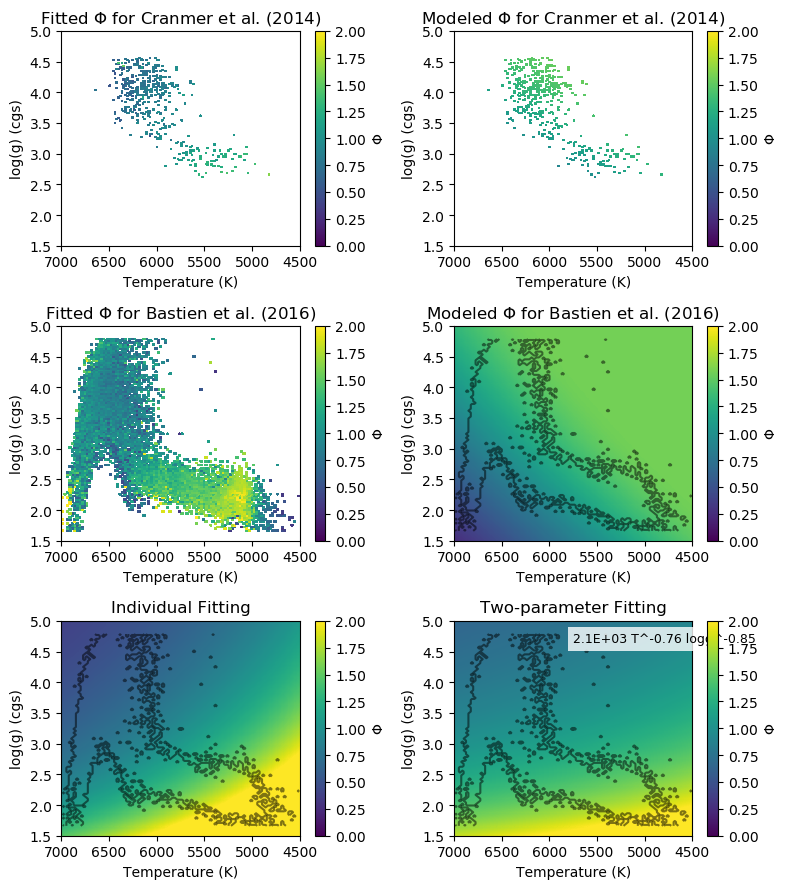

In [20]:
plt.figure(figsize=(8,9))
make_four_plots(catalog, make_Tg_plotter(), six_plots=True)
plt.savefig('fitting_phi_Tg.png', dpi=200)
plt.show()
#plt.clf()